In [1]:
import sys
sys.path.append("/home/ly/workspace/mmsa")
seed = 221
import numpy as np
import torch
from torch import nn
from torch import optim

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
from models.lymodel2 import *
from utils.train import *
from typing import *
from collections import Counter
from utils.load_yelp import *
from utils.dataset import *
from utils.train import *
from utils.train import *

In [2]:
config

{'task': 'CLS',
 'embedding_dim': 100,
 'embedding': None,
 'freeze_embedding': False,
 'text_hidden_size': 100,
 'text_layers': 1,
 'max_tokens': 512,
 'uniform_bound': 0.1,
 'img_input_size': 2048,
 'img_encoder_layers': 1,
 'attention_nhead': 4,
 'fusion_hidden_size': 400,
 'funsion_layers': 1,
 'dropout': 0.1,
 'output_size': 5,
 'bias_init': 1.0}

In [3]:
train_set, valid_set, test_set= load_glove_data(config)

In [4]:
%%time
batch_size = 64
workers = 4
train_loader, valid_loader, test_loader = get_loader(batch_size, workers, get_collate_fn(config), train_set, valid_set, test_set)

CPU times: user 169 µs, sys: 14 µs, total: 183 µs
Wall time: 190 µs


In [5]:
model = Model(config).cuda()
loss = nn.CrossEntropyLoss()
get_parameter_number(model), loss

/home/ly/miniconda3/envs/torch1.6.0/lib/python3.7/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


({'Total': 6904005, 'Trainable': 6904005}, CrossEntropyLoss())

In [6]:
%%time
y_true, y_pred, _loss = predict(model, valid_loader, loss)
evalute(y_true, y_pred), Counter(y_pred)

CPU times: user 4.72 s, sys: 2.27 s, total: 6.99 s
Wall time: 9.47 s


((0.21738148984198646, 0.1256220422113529),
 Counter({1: 2401, 3: 2011, 2: 17, 0: 1}))

In [7]:
viz = get_Visdom()
_interval = 5
batch_loss_drawer = VisdomScalar(viz, f"batch_loss interval:{_interval}")
epoch_loss_drawer = VisdomScalar(viz, f"Train and valid loss", 2)
acc_drawer = VisdomScalar(viz, "Train and valid accuracy", 2)

batch_loss = []
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []


Setting up a new session...


In [8]:
%%time
lr = 1e-3
epoches = 20
optimizer = get_regal_optimizer(model, optim.AdamW, lr)
res, model = train_visdom(model, optimizer, loss, viz, train_loader,
                          valid_loader, epoches, batch_loss, batch_loss_drawer,
                          train_loss, valid_loss, epoch_loss_drawer,
                          train_acc, valid_acc, acc_drawer,
                         _interval=_interval)

No 1 epoch:: 554it [01:56,  4.75it/s]


No 1 epoch: train_loss:1.211930614490404 train_acc:0.45461983354492874 valid_loss:0.9624101612153495 valid_acc:0.5765237020316027


No 2 epoch:: 554it [01:57,  4.72it/s]


No 2 epoch: train_loss:0.9491682652946857 train_acc:0.5775144590210185 valid_loss:0.905027728882654 valid_acc:0.600451467268623


No 3 epoch:: 554it [02:00,  4.62it/s]


No 3 epoch: train_loss:0.8345743206260672 train_acc:0.6387642826914939 valid_loss:0.9278006960791336 valid_acc:0.5934537246049661


No 4 epoch:: 554it [01:59,  4.64it/s]


No 4 epoch: train_loss:0.7067427776683485 train_acc:0.7078854563408097 valid_loss:0.9901516207992088 valid_acc:0.5790067720090294


No 5 epoch:: 554it [02:00,  4.61it/s]


No 5 epoch: train_loss:0.5659160665420471 train_acc:0.7757934828607702 valid_loss:1.1080868554707306 valid_acc:0.5799097065462754


No 6 epoch:: 554it [01:59,  4.63it/s]


No 6 epoch: train_loss:0.43495141334284143 train_acc:0.8367893920157992 valid_loss:1.3631083050376944 valid_acc:0.57313769751693


No 7 epoch:: 554it [01:59,  4.65it/s]


No 7 epoch: train_loss:0.32786588374121195 train_acc:0.8787981379602201 valid_loss:1.6167954019714423 valid_acc:0.5611738148984199
CPU times: user 11min 6s, sys: 3min 13s, total: 14min 19s
Wall time: 15min 2s


In [9]:
res

{'max_acc': 0.600451467268623,
 'max_acc_epoch': 2,
 'max_train_acc': 0.5775144590210185,
 'max_acc_train_loss': 0.9491682652946857,
 'max_acc_valid_loss': 0.905027728882654,
 'last_acc': 0.5611738148984199,
 'last_train_acc': 0.8787981379602201,
 'last_epoch': 7,
 'last_train_loss': 0.32786588374121195,
 'last_valid_loss': 1.6167954019714423}

In [10]:
eval_model(model, test_loader, loss)

/home/ly/miniconda3/envs/torch1.6.0/lib/python3.7/site-packages/torch/nn/modules/rnn.py:738: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/aten/src/ATen/native/cudnn/RNN.cpp:1234.)
  self.num_layers, self.dropout, self.training, self.bidirectional)


((0.5984198645598194, 0.5895372959542928), 0.8921092320511088)

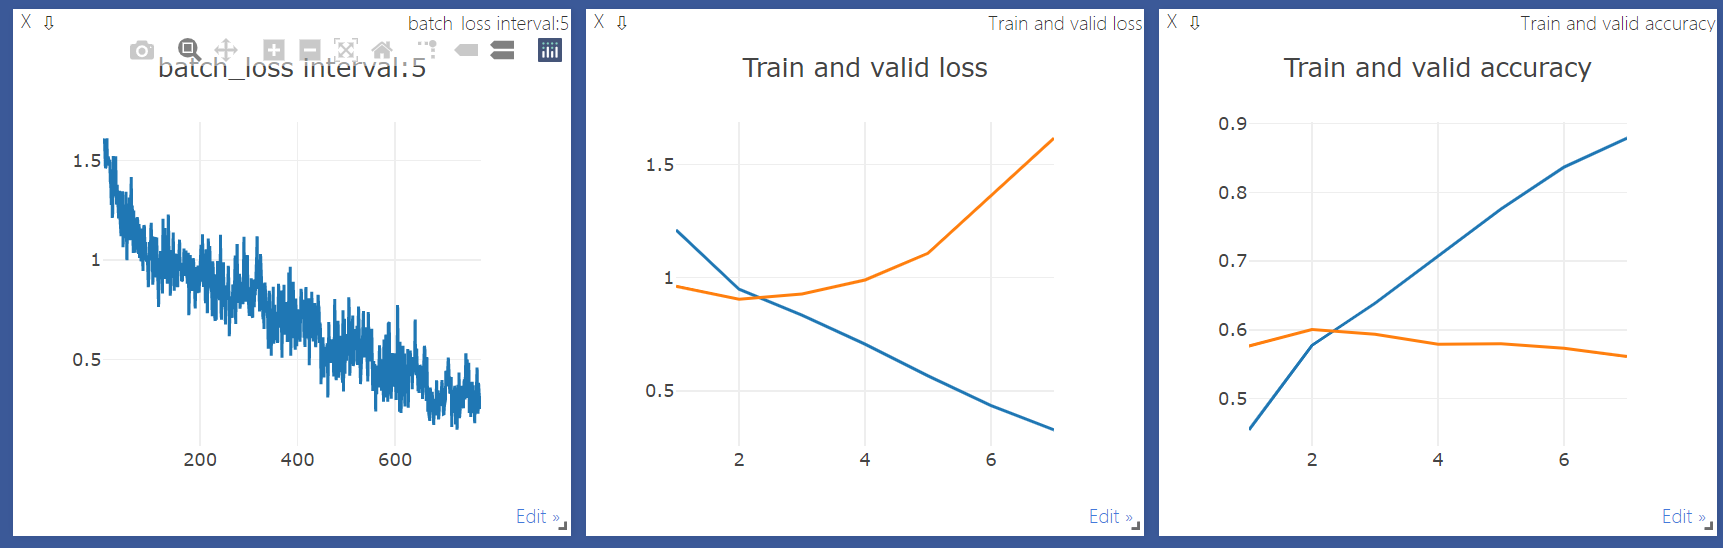